# Visualize Attention Notebook

In [1]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

import utils
import vision_transformer as vits
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

# Functions

In [2]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

In [3]:
arch = 'vit_small'
patch_size = 8
pretrained_weights = 'vit_small'
checkpoint_key = None
image_path = './data/images/2021-07-12 07:35:03-07:00.png'

image_size = (592, 1184)
output_dir = '.'
threshold = None

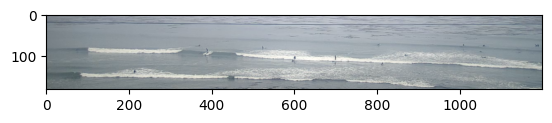

In [4]:
plt.imshow(plt.imread(image_path))
plt.show()

# Load Model

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# build model
model = vits.__dict__[arch](patch_size=patch_size, num_classes=0)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)
if os.path.isfile(pretrained_weights):
    state_dict = torch.load(pretrained_weights, map_location="cpu")
    if checkpoint_key is not None and checkpoint_key in state_dict:
        print(f"Take key {checkpoint_key} in provided checkpoint dict")
        state_dict = state_dict[checkpoint_key]
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
    print('Pretrained weights found at {} and loaded with msg: {}'.format(pretrained_weights, msg))
else:
    print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
    url = None
    if arch == "vit_small" and patch_size == 16:
        url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
    elif arch == "vit_small" and patch_size == 8:
        url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"  # model used for visualizations in our paper
    elif arch == "vit_base" and patch_size == 16:
        url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
    elif arch == "vit_base" and patch_size == 8:
        url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
    if url is not None:
        print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
        state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
        model.load_state_dict(state_dict, strict=True)
    else:
        print("There is no reference weights available for this model => We use random weights.")

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


# Open Image

In [6]:
# open image
if image_path is None:
    # user has not specified any image - we use our own image
    print("Please use the `--image_path` argument to indicate the path of the image you wish to visualize.")
    print("Since no image path have been provided, we take the first image in our paper.")
    response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB')
elif os.path.isfile(image_path):
    with open(image_path, 'rb') as f:
        img = Image.open(f)
        img = img.convert('RGB')
else:
    print(f"Provided image path {image_path} is non valid.")
    sys.exit(1)
orig = img.copy()


In [7]:
transform = pth_transforms.Compose([
    pth_transforms.Resize(image_size),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
# transform = pth_transforms.Compose([
#     pth_transforms.Resize(image_size),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])
img = transform(img)
type(img)

torch.Tensor

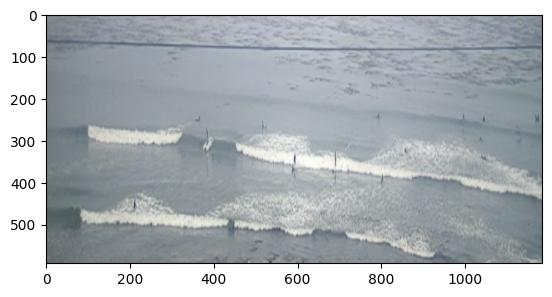

In [8]:
my_resize = pth_transforms.Compose([
    pth_transforms.Resize(image_size)
])
resize_orig = my_resize(orig)
plt.imshow(resize_orig)
plt.show()

In [9]:
# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

In [10]:
img.shape

torch.Size([1, 3, 592, 1184])

In [11]:
attentions = model.get_last_selfattention(img.to(device))
print(attentions.shape)

/Users/lukethomas/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/Users/lukethomas/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3657: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


In [ ]:
#model.patch_embed(img.to(device)).shape

In [ ]:

nh = attentions.shape[1] # number of head

print(attentions.shape)
# we keep only the output patch attention
output_patch = 0
my_patch = 0
heatmap = attentions[0, :, my_patch, 1:].reshape(nh, -1)
print('after reshape',heatmap.shape)
heatmap = heatmap.reshape(nh, w_featmap, h_featmap)
print('after reshape',heatmap.shape)
heatmap = nn.functional.interpolate(heatmap.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
print('after interpolate',heatmap.shape)


torch.Size([1, 6, 3301, 3301])
after reshape torch.Size([6, 3300])
after reshape torch.Size([6, 22, 150])
after interpolate (6, 176, 1200)


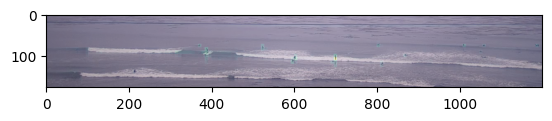

In [ ]:
plt.imshow(resize_orig)
#[plt.imshow(attentions[i], alpha = .1) for i in range(3)]
plt.imshow(heatmap.sum(0), alpha = .2)
plt.show()

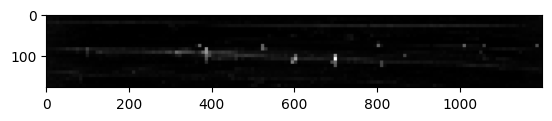

In [ ]:
heatimg = heatmap.sum(0).astype('double')
plt.imshow(heatimg, cmap = 'gray')
plt.show()

In [ ]:
from skimage.feature import blob_dog, blob_doh, blob_log
blobs = blob_doh(heatimg*256, threshold=0.05, min_sigma = 10, max_sigma=50)
blobs

/Users/lukethomas/opt/anaconda3/lib/python3.8/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/Users/lukethomas/opt/anaconda3/lib/python3.8/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/Users/lukethomas/opt/anaconda3/lib/python3.8/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/Users/lukethomas/opt/anaconda3/lib/python3.8/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


array([[ 123.        ,  623.        ,   23.33333333],
       [ 122.        ,  568.        ,   23.33333333],
       [ 117.        ,  812.        ,   10.        ],
       [ 108.        ,  748.        ,   10.        ],
       [ 107.        ,  682.        ,   41.11111111],
       [ 103.        ,  327.        ,   32.22222222],
       [  98.        ,  868.        ,   10.        ],
       [  95.        ,  535.        ,   32.22222222],
       [  93.        ,  408.        ,   50.        ],
       [  93.        ,   87.        ,   10.        ],
       [  90.        ,  130.        ,   10.        ],
       [  88.        ,  614.        ,   14.44444444],
       [  88.        ,  592.        ,   14.44444444],
       [  84.        ,  100.        ,   10.        ],
       [  84.        ,   74.        ,   10.        ],
       [  76.        , 1186.        ,   10.        ],
       [  76.        , 1058.        ,   10.        ],
       [  76.        , 1010.        ,   10.        ],
       [  74.        ,  804.

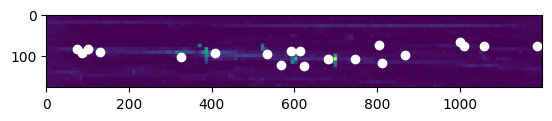

In [ ]:
plt.imshow(heatimg)
plt.scatter(blobs[:, 1], blobs[:, 0], c='white')
plt.show()

# Cycle through attention heads
imageio required

In [ ]:
import imageio

def save(GIF_list):
    plt.savefig('temp_img.png') 
    GIF_list.append(imageio.imread('temp_img.png')) 

GIF_list = []
for i in range(6): 
    plt.imshow(resize_orig)
    plt.imshow(heatmap[i], alpha = .35)
    plt.title(f'My Attention Head {i}')
    save(GIF_list)
    plt.clf()
plt.show()
os.remove('temp_img.png')
imageio.mimsave('test.gif', GIF_list,fps = 1)


<Figure size 640x480 with 0 Axes>

![test](test.gif)
